# Stacking

### Idea
Because training base models is hard, the possible optimal solution may be to take a lot of classical models
for portfolio creation and train a 2nd-layer model on their outputs, to select an optimal output.

The challenges we need to solve in this notebook are the following:
- selecting a target variable and metric
- generating as many simple models as possible
- adding features related to the long-term trends for 2nd layer model for it to perform a "more informed" choice
- choosing whether base models should be allowed to see entire past that we have or just the most recent fraction of it

### Loading data

In [1]:
import pandas as pd
import numpy as np

from utils.data_loader import load_all

In [2]:
df = load_all()
df = df.loc[~df['AP'].isna()]
df.head()

,AP,ARR,ARW,G,OP,ORR,ORW,a5.c,wig2,^aex,...,SEK,CHF,THB,TTD,TND,AED,GBP,USD,UYU,VEB
2000-01-03,415.90,549.11,354.45,401.26,275.08,520.13,230.72,1204.88,1852.9,675.44,...,0.085771,0.456726,NaN,0.115867,NaN,0.197875,NaN,0.726696,NaN,NaN
2000-01-04,404.41,533.89,357.14,401.42,275.08,520.02,229.63,1194.41,1796.6,642.25,...,NaN,0.465253,0.019568,0.115445,NaN,0.197034,1.18701,0.723608,NaN,0.001114
2000-01-05,400.04,527.38,351.19,401.59,275.08,519.22,229.22,1192.89,1777.0,632.31,...,0.086740,0.466615,0.019422,0.115510,NaN,0.197039,1.18624,0.723627,NaN,0.001114
2000-01-06,410.15,522.02,347.96,401.75,275.07,519.62,228.82,NaN,1832.1,624.21,...,NaN,0.468650,0.019427,0.115662,NaN,0.197260,1.19474,0.724439,NaN,0.001115
2000-01-07,429.16,533.16,351.87,401.93,275.07,520.80,230.09,1223.61,1933.2,644.86,...,NaN,0.465233,0.019410,0.115876,NaN,0.197989,1.19596,0.727113,NaN,0.001118


In [3]:
df.shape

(4801, 200)

In [4]:
fund_colnames = ['AP', 'ARR', 'ARW', 'G', 'OP', 'ORR', 'ORW']

In [5]:
funds_df = df[fund_colnames]

In [6]:
funds_df.shape

(4801, 7)

### Feature and target selection

Firstly, we will try to train a classifier that selects the best performing model.

In [7]:
from typing import List, Callable, Tuple
from dataclasses import dataclass, asdict

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

from numba import jit

from tqdm import tqdm

In [8]:
year_days = int(funds_df.groupby(funds_df.index.year).count().mean().mean())
month_days = int(year_days/12)
week_days = int(month_days/4)
print(f"Using default number of trading days in a year={year_days}, month={month_days}, week={week_days}")

max_volatility = 0.1
print(f"Using volatility threshold={max_volatility}")

Using default number of trading days in a year=252, month=21, week=5
Using volatility threshold=0.1


In [9]:
@dataclass
class Portfolio(object):
    AP: float
    ARR: float
    ARW: float
    G: float
    OP: float
    ORR: float
    ORW: float

    def as_weights(self):
        return np.array(list(asdict(self).values()))


def risk_free_rate(table, interval_len_in_days: int=1) -> int:
    """ For the purpose of this portfolio selection, we use G (cash fund returns) as a risk-free rate. """
    intervals_in_a_year = year_days / interval_len_in_days
    return np.mean((df['G'].shift(1) - df['G'].iloc[:-1]) / df['G'].iloc[:-1]) * intervals_in_a_year


def _ef_builder(table):
    """ Builder for all kinds of efficient frontier models. """
    table = table.copy().groupby(by=[table.index.year, table.index.month]).tail(n=1)
    mu = mean_historical_return(table)
    S = CovarianceShrinkage(table).ledoit_wolf()
    return EfficientFrontier(mu, S)

def _ef_meta_builder(ef):
    """ 
    Common metadata for all kinds of efficient frontier models:
    expected annualized returns, expected volatility, sharpe ratio
    """
    return np.array(ef.portfolio_performance())

def ef_max_sharpe(table, interval: int=1):
    ef = _ef_builder(table)
    weights = ef.max_sharpe(risk_free_rate(interval))
    return Portfolio(**weights), _ef_meta_builder(ef)

def ef_min_volatility(table, interval: int=1):
    ef = _ef_builder(table)
    weights = ef.min_volatility()
    return Portfolio(**weights), _ef_meta_builder(ef)

def ef_efficient_risk(table, risk_target: float, interval: int=1):
    ef = _ef_builder(table)
    weights = ef.efficient_risk(risk_target, risk_free_rate=risk_free_rate(interval))
    return Portfolio(**weights), _ef_meta_builder(ef)

def ef_efficient_return(table, target_return, interval: int=1):
    ef = _ef_builder(table)
    weights = ef.efficient_return(target_return)
    return Portfolio(**weights), _ef_meta_builder(ef)

In [10]:
def calculate_features(funds_df: pd.DataFrame) -> Tuple[np.array, List[Portfolio]]:
    """
    Returns features for the model along with the portfolios that were used for calculating these features.
    """
    monthly_table = funds_df.groupby([funds_df.index.year, funds_df.index.month]).tail(1)
    weekly_table = funds_df.groupby([funds_df.index.year, funds_df.index.week]).tail(1)
    portfolio_data = [
        ef_max_sharpe(funds_df),
        ef_max_sharpe(monthly_table, month_days),
        ef_max_sharpe(weekly_table, week_days),
        ef_min_volatility(funds_df),
        ef_min_volatility(monthly_table, month_days),
        ef_min_volatility(weekly_table, week_days),
        ef_efficient_risk(funds_df, 0.10),
        ef_efficient_risk(funds_df, 0.05),
        ef_efficient_risk(monthly_table, 0.10, month_days),
        ef_efficient_risk(monthly_table, 0.05, month_days),
        ef_efficient_risk(weekly_table, 0.10, week_days),
        ef_efficient_risk(weekly_table, 0.05, week_days),
        ef_efficient_return(funds_df, 0.04),
        ef_efficient_return(funds_df, 0.08),
        ef_efficient_return(monthly_table, 0.04, month_days),
        ef_efficient_return(monthly_table, 0.08, month_days),
        ef_efficient_return(weekly_table, 0.04, week_days),
        ef_efficient_return(weekly_table, 0.08, week_days),
    ]
    portfolios = [pd[0] for pd in portfolio_data]
    portfolio_weights = np.hstack([p.as_weights() for p in portfolios])
    portfolio_features = np.hstack(pd[1] for pd in portfolio_data)
    return np.hstack([portfolio_weights, portfolio_features]), portfolios
    

@jit(nopython=True)
def portfolio_performance(portfolio_allocation: np.array, fund_df_values: np.array) -> Tuple[float, float]:
    fund_returns = (fund_df_values[-1] - fund_df_values[0]) / fund_df_values[0]
    portfolio_returns = np.sum(portfolio_allocation*fund_returns) / np.sum(portfolio_allocation)
    # eliminating portfolios based on too high volatility
    portfolio_period_values = np.sum(portfolio_allocation*fund_df_values[:-1], axis=1) / np.sum(portfolio_allocation)
    portfolio_period_shifted = np.sum(portfolio_allocation*fund_df_values[1:], axis=1) / np.sum(portfolio_allocation)
    portfolio_daily_returns = (portfolio_period_shifted - portfolio_period_values) / portfolio_period_values
    portfolio_volatility = np.var(portfolio_daily_returns)
    if portfolio_volatility > max_volatility:
        print("Exceeded max volatility:", portfolio_volatility)
        return -np.inf
    else:
        return portfolio_returns

In [11]:
%%time
features, pfs = calculate_features(funds_df)
print(features.shape, len(pfs), pfs[0])

(180,) 18 Portfolio(AP=2.8675560682935483e-16, ARR=0.0241814682778109, ARW=0.0, G=0.6310321596791412, OP=0.18473105611147625, ORR=0.13726016068669422, ORW=0.0227951552448774)
CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 1.43 s


In [12]:
portfolio_performance(np.array([0,0,0,0,0,0,1]), funds_df.values)

3.334257975034674

In [13]:
def compute_X_y(
        funds_df: pd.DataFrame,
        n_features: int,
        min_test_idx: int=5*year_days, 
        test_len: int=year_days
    ):
    max_test_idx = len(funds_df)
    n_samples = max_test_idx - min_test_idx - test_len
    X = np.zeros((n_samples, n_features))
    y = np.zeros(n_samples)
    sample_weights = np.zeros(n_samples)
    for idx in tqdm(range(n_samples)):
        test_starting_idx = min_test_idx + idx
        present_data = funds_df.iloc[:test_starting_idx]
        test_data = funds_df.iloc[test_starting_idx:test_starting_idx+test_len]
        X[idx], portfolios = calculate_features(present_data)
        portfolio_performances = np.array([portfolio_performance(p.as_weights(), test_data.values) for p in portfolios])
        y[idx] = np.argmax(portfolio_performances)
        sample_weights[idx] = 1 + np.max(portfolio_performances) - np.mean(portfolio_performances[portfolio_performances > -np.inf])
    return X, y, sample_weights

In [14]:
X, y, sample_weights = compute_X_y(funds_df, n_features=180)

100%|██████████| 3289/3289 [1:31:19<00:00,  1.75s/it]


In [15]:
y = y.astype(np.int)

In [16]:
X.shape, y.shape, X.dtype, y.dtype

((3289, 180), (3289,), dtype('float64'), dtype('int64'))

In [17]:
%%time
filename = "18-funds-data-" + str(pd.datetime.now().date())
print(filename)
np.save(f'data/{filename}-X.npy', X)
np.save(f'data/{filename}-y.npy', y)
np.save(f'data/{filename}-weights.npy', sample_weights)

18-funds-data-2019-03-09
CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 8.64 ms


### Training the model

In [18]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.multioutput import MultiOutputRegressor

from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

import seaborn as sns

In [53]:
pd.value_counts(y)

16    744
13    553
12    550
17    538
0     433
2     242
6     118
10     76
5      14
7      10
3      10
11      1
dtype: int64

We are not shuffling during the test set separation in order not to let the model know about macro trends that might appear in the future and are not captured within our set of input features.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2631, 180), (2631,), (658, 180), (658,))

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2104, 180), (2104,), (527, 180), (527,), (658, 180), (658,))

In [56]:
weights_train = sample_weights[:y_train.shape[0]]
weights_val = sample_weights[y_train.shape[0]:y_train.shape[0]+y_val.shape[0]]
weights_test = sample_weights[y_train.shape[0]+y_val.shape[0]:]

Some of the classes will never be predicted because they are not present in the training set.

For now, we will just remove the rarely occuring values from the entire dataset and work on the ones that can be split efficiently.

In [57]:
np.unique(y_train), np.unique(y_val), np.unique(y_test)

(array([ 0,  2,  3,  5,  6, 10, 11, 12, 13, 16, 17]),
 array([ 0,  3,  7, 12, 13, 16, 17]),
 array([ 0,  2,  6,  7, 12, 13, 16, 17]))

In [58]:
keep_indices = np.isin(y_val, np.unique(y_train))
X_val, y_val, weights_val = X_val[keep_indices], y_val[keep_indices], weights_val[keep_indices]
print(X_val.shape, y_val.shape, weights_val.shape)

(524, 180) (524,) (524,)


In [85]:
lgbm_params = {
#     Learning params:
    'num_leaves': 32,
    'learning_rate': 0.0012137,
    'n_estimators': 4096,
#     Regularization:
    'lambda_l1': 0.25,
#     Technical:
    'silent': True,
    'n_jobs': 4,
    'num_class': 18
}

In [86]:
gbm = LGBMClassifier(**lgbm_params)
gbm.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_val, y_val)],
    eval_sample_weight=[weights_val],
    eval_metric='multi_logloss',
    early_stopping_rounds=128,
    verbose=256
)

Training until validation scores don't improve for 128 rounds.
[256]	valid_0's multi_logloss: 1.67704	valid_0's multi_logloss: 1.67704
[512]	valid_0's multi_logloss: 1.63565	valid_0's multi_logloss: 1.63565
[768]	valid_0's multi_logloss: 1.60535	valid_0's multi_logloss: 1.60535
[1024]	valid_0's multi_logloss: 1.58497	valid_0's multi_logloss: 1.58497
[1280]	valid_0's multi_logloss: 1.5629	valid_0's multi_logloss: 1.5629
[1536]	valid_0's multi_logloss: 1.54343	valid_0's multi_logloss: 1.54343
[1792]	valid_0's multi_logloss: 1.53339	valid_0's multi_logloss: 1.53339
Early stopping, best iteration is:
[1772]	valid_0's multi_logloss: 1.53331	valid_0's multi_logloss: 1.53331


0.135258358662614

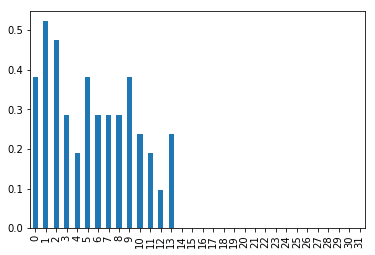

In [103]:
y_pred = gbm.predict(X_test)
batch_scores = pd.Series([
    accuracy_score(
        y_test[batch_idx:min(y_test.shape[0], batch_idx+month_days)], 
        y_pred[batch_idx:min(y_pred.shape[0], batch_idx+month_days)]
    ) for batch_idx in range(0,y_test.shape[0],month_days)
])
batch_scores.plot(kind='bar')

We can see how quickly the model performance drops when dynamics of the financial markets change beyond what the model has seen in training.

This is no surprise, since all of the features are highly correlated and we have no way of capturing these long-term substantial changes right now.

#### Re-training with important features only

In [107]:
np.count_nonzero(gbm.feature_importances_)

116

In [113]:
important_features = gbm.feature_importances_ != 0
X_train = X_train[:,important_features]
X_val = X_val[:,important_features]
X_test = X_test[:,important_features]

In [114]:
final_lgbm_params = {
#     Learning params:
    'num_leaves': 32,
    'learning_rate': 0.0012137,
    'n_estimators': 4096,
#     Regularization:
    'lambda_l2': 0.1,
#     Technical:
    'silent': True,
    'n_jobs': 4,
    'num_class': 18
}

In [116]:
gbm = LGBMClassifier(**final_lgbm_params)
gbm.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_val, y_val)],
    eval_sample_weight=[weights_val],
    eval_metric='multi_logloss',
    early_stopping_rounds=128,
    verbose=256
)

Training until validation scores don't improve for 128 rounds.
[256]	valid_0's multi_logloss: 1.67782	valid_0's multi_logloss: 1.67782
[512]	valid_0's multi_logloss: 1.6364	valid_0's multi_logloss: 1.6364
[768]	valid_0's multi_logloss: 1.60431	valid_0's multi_logloss: 1.60431
[1024]	valid_0's multi_logloss: 1.5828	valid_0's multi_logloss: 1.5828
[1280]	valid_0's multi_logloss: 1.5552	valid_0's multi_logloss: 1.5552
[1536]	valid_0's multi_logloss: 1.53407	valid_0's multi_logloss: 1.53407
Early stopping, best iteration is:
[1628]	valid_0's multi_logloss: 1.53039	valid_0's multi_logloss: 1.53039


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', lambda_l2=0.1, learning_rate=0.0012137,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=4096, n_jobs=4, num_class=18,
        num_leaves=32, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

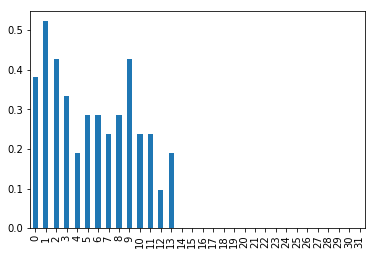

In [117]:
y_pred = gbm.predict(X_test)
batch_scores = pd.Series([
    accuracy_score(
        y_test[batch_idx:min(y_test.shape[0], batch_idx+month_days)], 
        y_pred[batch_idx:min(y_pred.shape[0], batch_idx+month_days)]
    ) for batch_idx in range(0,y_test.shape[0],month_days)
])
batch_scores.plot(kind='bar')

This does not look any better, let's see how the score changes when the 2nd layer model has more data about markets themselves.

### Adding time series features

In [129]:
returns_aggs = ['min', 'max', 'mean', 'var', 'skew', 'kurt']

def aggregated_returns(df: pd.DataFrame, aggs=returns_aggs) -> pd.DataFrame:
    returns = (df.shift(1) - df) / df
    return returns.agg(aggs)

In [136]:
funds_df.groupby(funds_df.index.year).tail(1).agg(returns_aggs).values.ravel().shape

(42,)

In [140]:
def compute_new_X(
        funds_df: pd.DataFrame,
        min_test_idx: int=5*year_days, 
        test_len: int=year_days
    ):
    max_test_idx = len(funds_df)
    n_samples = max_test_idx - min_test_idx - test_len
    n_returns_features = funds_df.shape[1]*len(returns_aggs)
    n_groupped_features = funds_df.shape[1]*len(returns_aggs)
    n_features = n_returns_features + n_groupped_features
    X = np.zeros((n_samples, n_features))
    for idx in tqdm(range(n_samples)):
        test_starting_idx = min_test_idx + idx
        present_data = funds_df.iloc[:test_starting_idx]
        X[idx,:n_returns_features] = aggregated_returns(present_data, returns_aggs).values.ravel()
        X[idx,n_returns_features:] = present_data.agg(returns_aggs).values.ravel()
    return X

In [141]:
X_features = compute_new_X(funds_df)

100%|██████████| 3289/3289 [01:46<00:00, 30.93it/s]


We will now re-train the model, once again with feature selection by applying hard l1 regularization.

In [182]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack([X, X_features]), y, test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2631, 264), (2631,), (658, 264), (658,))

In [183]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2104, 264), (2104,), (527, 264), (527,), (658, 264), (658,))

In [184]:
weights_train = sample_weights[:y_train.shape[0]]
weights_val = sample_weights[y_train.shape[0]:y_train.shape[0]+y_val.shape[0]]
weights_test = sample_weights[y_train.shape[0]+y_val.shape[0]:]

Some of the classes will never be predicted because they are not present in the training set.

For now, we will just remove the rarely occuring values from the entire dataset and work on the ones that can be split efficiently.

In [185]:
np.unique(y_train), np.unique(y_val), np.unique(y_test)

(array([ 0,  2,  3,  5,  6, 10, 11, 12, 13, 16, 17]),
 array([ 0,  3,  7, 12, 13, 16, 17]),
 array([ 0,  2,  6,  7, 12, 13, 16, 17]))

In [186]:
keep_indices = np.isin(y_val, np.unique(y_train))
X_val, y_val, weights_val = X_val[keep_indices], y_val[keep_indices], weights_val[keep_indices]
print(X_val.shape, y_val.shape, weights_val.shape)

(524, 264) (524,) (524,)


In [187]:
lgbm_params = {
#     Learning params:
    'num_leaves': 32,
    'learning_rate': 0.0002137,
    'n_estimators': 4096,
#     Regularization:
    'lambda_l1': 0.025,
    'subsample': 0.75,
#     Technical:
    'silent': True,
    'n_jobs': 12,
    'num_class': 18
}

In [161]:
gbm = LGBMClassifier(**lgbm_params)
gbm.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_val, y_val)],
    eval_sample_weight=[weights_val],
    eval_metric='multi_logloss',
    early_stopping_rounds=512,
    verbose=256
)

Training until validation scores don't improve for 512 rounds.
[256]	valid_0's multi_logloss: 1.7526	valid_0's multi_logloss: 1.7526
[512]	valid_0's multi_logloss: 1.75241	valid_0's multi_logloss: 1.75241
[768]	valid_0's multi_logloss: 1.7568	valid_0's multi_logloss: 1.7568
Early stopping, best iteration is:
[390]	valid_0's multi_logloss: 1.75186	valid_0's multi_logloss: 1.75186


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', lambda_l1=0.025, learning_rate=0.0002137,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=4096, n_jobs=12, num_class=18,
        num_leaves=32, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.75,
        subsample_for_bin=200000, subsample_freq=0)

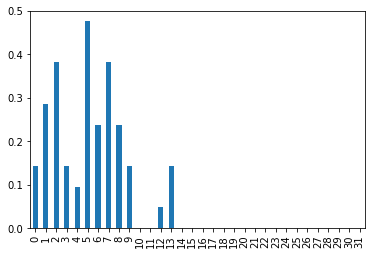

In [162]:
y_pred = gbm.predict(X_test)
batch_scores = pd.Series([
    accuracy_score(
        y_test[batch_idx:min(y_test.shape[0], batch_idx+month_days)], 
        y_pred[batch_idx:min(y_pred.shape[0], batch_idx+month_days)]
    ) for batch_idx in range(0,y_test.shape[0],month_days)
])
batch_scores.plot(kind='bar')

In [170]:
np.min(np.corrcoef(X_features)), np.mean(np.corrcoef(X_features))

(0.6391014317674686, 0.9374953620982656)

In [171]:
np.min(np.corrcoef(X)), np.mean(np.corrcoef(X))

(0.9412195422994778, 0.9827917097014088)

In [174]:
# old features, new features
gbm.feature_importances_[X_features.shape[1]:].mean(), gbm.feature_importances_[:X_features.shape[1]].mean()

(290.0722222222222, 166.77380952380952)

For some reason, the model does not take advantage of the additional features that it was given.

The problem is, that most of the features are strongly correlated anyway, same goes for the base-layer PyPortfolioOpt models.

### Reducing dimentionality with PCA

In [188]:
from sklearn.decomposition import PCA

In [189]:
%%time
pca = PCA(n_components=120)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

CPU times: user 728 ms, sys: 0 ns, total: 728 ms
Wall time: 62.4 ms


In [190]:
lgbm_params = {
#     Learning params:
    'num_leaves': 32,
    'learning_rate': 0.0002137,
    'n_estimators': 4096,
#     Regularization:
    'lambda_l1': 0.025,
    'subsample': 0.75,
#     Technical:
    'silent': True,
    'n_jobs': 12,
    'num_class': 18
}

In [191]:
gbm = LGBMClassifier(**lgbm_params)
gbm.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_val, y_val)],
    eval_sample_weight=[weights_val],
    eval_metric='multi_logloss',
    early_stopping_rounds=512,
    verbose=256
)

Training until validation scores don't improve for 512 rounds.
[256]	valid_0's multi_logloss: 1.76753	valid_0's multi_logloss: 1.76753
[512]	valid_0's multi_logloss: 1.77788	valid_0's multi_logloss: 1.77788
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.76212	valid_0's multi_logloss: 1.76212


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', lambda_l1=0.025, learning_rate=0.0002137,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=4096, n_jobs=12, num_class=18,
        num_leaves=32, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.75,
        subsample_for_bin=200000, subsample_freq=0)

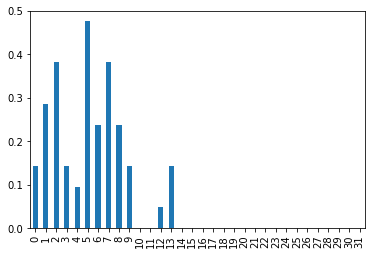

In [192]:
y_pred = gbm.predict(X_test)
batch_scores = pd.Series([
    accuracy_score(
        y_test[batch_idx:min(y_test.shape[0], batch_idx+month_days)], 
        y_pred[batch_idx:min(y_pred.shape[0], batch_idx+month_days)]
    ) for batch_idx in range(0,y_test.shape[0],month_days)
])
batch_scores.plot(kind='bar')

As expected, this was a total disaster.

# Conclusions & next steps

Next step would be to train an LSTM on these time series, which should nicely take care of correlated input.
Additionally, we will be able to compute a custom loss that will basically optimize the return for the given maximum risk threshold.

Additionally, it is important to take into account that we aimed to classify which base model performs the best, which is likely the harder task than selecting an optimal portfolio based on base-model portfolio selections.
This, however, would be much harder to implement using gradient boosting models and we will explore this approach when building our LSTM.